# Drag AMPERE

Ivestigate density and AMPERE data

Find the indices where the MLT and Colat of AMPERE matches that of the spacecraft

## Datasets

Use the normalized datasets. 
- satdrag_database_grace_B.hdf5
- satdrag_database_grace_C.hdf5
- satdrag_database_grace_CHAMP.hdf5



In [1]:
#print all output in a cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [94]:
import pandas as pd
import numpy as np
import netCDF4 as nc
import seaborn as sns

# for converting to
# geomagnetic coord
import aacgmv2



In [17]:
# min and max lat
lmin = 30
lmax = 90

# magnetic min and max
mlmin = 40
mlmax = 90

# date range (for AMPERE data)
dmin = '2009-01-01'
dmax = '2013-01-01'

# satellite to use
sat = 'B'
data_f=f"D:/data/SatDensities/satdrag_database_grace_{sat}.hdf5"

# ampere file
# single file to find indexes of closest encounter
data_amp = "E:\\OneDrive\\data\\AMPERE\\ampere.20091002.k060_m08.north.grd.nc"

# ampere database
db_amp = 'C:/data/ampere_jpar.hdf5'

In [4]:
sat_df = pd.read_hdf(data_f)

In [5]:
#define the latitude and time masks
gd_t = (sat_df['DateTime'] >= dmin) & (sat_df['DateTime'] <= dmax)
gd_lat = (sat_df['SatLat'] >= lmin) & (sat_df['SatLat'] <= lmax)

In [6]:
#truncate the array so fewer aacgm 
# calculations need to be done
sat_sm = sat_df[gd_t & gd_lat].copy().reset_index()
sat_sm.shape
sat_sm.columns

(93625, 80)

Index(['index', 'DateTime', 'DateTime_omni', 'B', 'Bx_GSEGSM', 'By_GSE',
       'Bz_GSE', 'By_GSM', 'Bz_GSM', 'Vsw', 'Vx_GSE', 'Vy_GSE', 'Vz_GSE',
       'Prho', 'Tp', 'dynP', 'Esw', 'AE', 'AL', 'AU', 'SYM_D index',
       'SYM_H index', 'ASY_D index', 'ASY_H index', 'PC index',
       'Goes Proton flux (>10 MeV)', 'Goes Proton flux (>30 MeV)',
       'Goes Proton flux (>60 MeV)', 'DateTime_fism2', '225_00', '600_01',
       '1300_02', '2500_03', '5100_04', '11250_05', '18950_06', '25700_07',
       '30500_08', '43000_09', '59500_10', '72400_11', '72400_12', '85550_13',
       '85550_14', '85550_15', '94400_16', '94400_17', '94400_18', '98100_19',
       '100700_20', '103850_21', '113000_22', 'DateTime_si', 'F10', 'F81',
       'S10', 'S81c', 'M10', 'M81c', 'Y10', 'Y81c', 'DateTime_gr', 'CenterLat',
       'SatLat', 'SatLon', 'SatHeight', 'SatLT', 'SatDipoleLat', 'SatMagLon',
       'SatMagLT', 'SatDensity', '400kmDensity', '410kmDensity',
       'NRLMSISe00atSat', 'DenUncertainty', 'N

In [7]:
lat = sat_sm['SatLat'].to_numpy()
lon = sat_sm['SatLon'].to_numpy()
alt = sat_sm['SatHeight'].to_numpy()
dt = pd.to_datetime(sat_sm['DateTime_gr'].to_numpy())

x = [
    aacgmv2.get_aacgm_coord(glat,glon,galt,gdt)
    for glat, glon, galt, gdt in 
    zip(lat,lon,alt,dt)
    ]

x = np.array(x)

In [8]:
# add the new coordinates and truncate to mag coordinates
sat_sm['Sat_mlat'] = x[:,0]
sat_sm['Sat_mlon'] = x[:,1]
sat_sm['Sat_mlt'] = x[:,2]

gd_ml = (sat_sm['Sat_mlat'] >= mlmin) & (sat_sm['Sat_mlat'] <= mlmax) 
sat_sm = sat_sm[gd_ml].copy()

# calculate magnetic colatitude
sat_sm['Sat_mcolat'] = 90-sat_sm['Sat_mlat']


In [11]:
# read in the AMPERE data to get
# the AMPERE colat/mlt grid
amp_dat = nc.Dataset(data_amp)
amp_colat = amp_dat['cLat_deg'][:][0,:]
amp_mlt = amp_dat['mlt_hr'][:][0,:]

amp_cos = np.cos(amp_mlt*np.pi/12)
amp_sin = np.sin(amp_mlt*np.pi/12)

amp_dat.close()

In [12]:
pos = [(np.power(amp_cos-np.cos(x_mlt*np.pi/12),2)+
        np.power(amp_sin-np.sin(x_mlt*np.pi/12),2)+
        +np.power(amp_colat-x_lat,2)).argmin() 
        for x_mlt, x_lat in zip(sat_sm['Sat_mlt'],sat_sm['Sat_mcolat'])]


In [13]:
sat_sm['Diff_colat'] = sat_sm['Sat_mcolat']-amp_colat[pos]
sat_sm['Diff_mlt'] = sat_sm['Sat_mlt']-amp_mlt[pos] 
bd = sat_sm['Diff_mlt'] > 23.5
sat_sm.loc[bd,'Diff_mlt'] = 24-sat_sm.loc[bd,'Diff_mlt'] 

In [14]:
sat_sm['AMP_idx'] = pos

In [ ]:
# read in the AMPERE J data
amp_j = pd.read_hdf(db_amp)

In [21]:
amp_j.head(2)
amp_j.tail(2)

,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,time
0,0.056975,0.037803,0.038518,0.049165,0.059672,0.060608,0.044058,0.006738,-0.046455,-0.101901,...,0.063134,0.062676,0.029469,-0.010243,-0.029591,-0.020619,0.002271,0.015732,0.006109,2009-10-02 00:00:00
1,0.059664,0.099800,0.142275,0.156618,0.131288,0.076095,0.011862,-0.043416,-0.082854,-0.109510,...,0.067157,0.063972,0.031553,-0.006913,-0.027982,-0.024404,-0.007964,0.001923,-0.006060,2009-10-02 00:02:00


,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,time
830857,0.313188,0.104983,-0.201180,-0.487034,-0.653939,-0.665766,-0.554674,-0.393590,-0.254671,-0.175695,...,-0.027898,-0.008100,0.003216,-0.002196,-0.014552,-0.014059,0.011940,0.056661,0.096190,2012-12-31 23:56:00
830858,0.467988,0.175269,-0.227166,-0.553026,-0.681096,-0.613403,-0.448238,-0.299346,-0.224489,-0.208459,...,-0.047851,-0.020221,0.010118,0.020646,0.007265,-0.013898,-0.020589,-0.002330,0.031484,2012-12-31 23:58:00


In [22]:
sat_sm.head(2)
sat_sm.tail(2)

,index,DateTime,DateTime_omni,B,Bx_GSEGSM,By_GSE,Bz_GSE,By_GSM,Bz_GSM,Vsw,...,AveDragCoef,storm,storm phase,Sat_mlat,Sat_mlon,Sat_mlt,Sat_mcolat,Diff_colat,Diff_mlt,AMP_idx
0,675366,2009-01-01 00:30:00,2009-01-01 00:30:00,4.59,-4.21,1.32,-1.06,1.55,-0.68,502.7,...,2.993,-1,-1,54.366397,-7.742894,18.799389,35.633603,-0.366397,-0.200611,985
1,675367,2009-01-01 00:35:00,2009-01-01 00:35:00,4.35,-3.78,1.29,-0.86,1.46,-0.51,509.8,...,3.141,-1,-1,71.509874,-7.789085,18.880697,18.490126,0.490126,-0.119303,967


,index,DateTime,DateTime_omni,B,Bx_GSEGSM,By_GSE,Bz_GSE,By_GSM,Bz_GSM,Vsw,...,AveDragCoef,storm,storm phase,Sat_mlat,Sat_mlon,Sat_mlt,Sat_mcolat,Diff_colat,Diff_mlt,AMP_idx
93623,1043135,2012-06-30 23:55:00,2012-06-30 23:55:00,7.11,2.11,-0.79,4.28,-1.23,4.17,656.4,...,3.452,-1,-1,80.380401,172.474658,6.745197,9.619599,-0.380401,-0.254803,359
93624,1043136,2012-07-01 00:00:00,2012-07-01 00:00:00,6.78,1.45,-1.49,6.06,-2.10,5.87,665.2,...,3.279,-1,-1,64.390042,-175.378677,7.627241,25.609958,-0.390042,-0.372759,425


In [ ]:
t_min = np.max([sat_sm['DateTime'].min(),amp_j['time'].min()])
t_max = np.min([sat_sm['DateTime'].max(),amp_j['time'].max()])




In [31]:
sat_sm = sat_sm[(sat_sm['DateTime'] >= t_min) & (sat_sm['DateTime'] <= t_max)]

In [32]:
amp_j = amp_j[(amp_j['time'] >= t_min) & (amp_j['time'] <= t_max)]

In [34]:
sat_idx = sat_sm[['DateTime','AMP_idx']]
amp_idx = amp_j.reset_index()[['index','time']]

In [43]:
#combine the arrays 
tol = pd.Timedelta('31 second')

c_idx = pd.merge_asof(left=sat_idx,right=amp_idx,left_on='DateTime',right_on='time',direction='nearest',tolerance=tol)

In [59]:
c_idx = c_idx.dropna()

In [48]:
amp_j.head(2)
amp_j.columns

,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,time
0,0.056975,0.037803,0.038518,0.049165,0.059672,0.060608,0.044058,0.006738,-0.046455,-0.101901,...,0.063134,0.062676,0.029469,-0.010243,-0.029591,-0.020619,0.002271,0.015732,0.006109,2009-10-02 00:00:00
1,0.059664,0.099800,0.142275,0.156618,0.131288,0.076095,0.011862,-0.043416,-0.082854,-0.109510,...,0.067157,0.063972,0.031553,-0.006913,-0.027982,-0.024404,-0.007964,0.001923,-0.006060,2009-10-02 00:02:00


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1191', '1192', '1193', '1194', '1195', '1196', '1197', '1198', '1199',
       'time'],
      dtype='object', length=1201)

In [60]:
sa_j = [amp_j.loc[id_x,id_j] for id_x, id_j in zip(c_idx['index'], c_idx['AMP_idx'].astype(str))]

In [63]:
sa_t = [amp_j.loc[id_x,'time'] for id_x, in zip(c_idx['index'])]

In [66]:
sa_df = pd.DataFrame({'AMP_j':sa_j, 'AMP_t':sa_t})
sa_df.head()

,AMP_j,AMP_t
0,-0.033705,2009-10-02 01:00:00
1,0.260517,2009-10-02 01:10:00
2,-0.027528,2009-10-02 01:20:00
3,0.026888,2009-10-02 02:40:00
4,-0.003254,2009-10-02 02:50:00


In [68]:
den_amp = pd.merge_asof(left=sat_sm,right=sa_df,left_on='DateTime',right_on='AMP_t',direction='nearest',tolerance=tol)

In [98]:
den_amp =  den_amp.dropna(axis=0, subset='AMP_j').copy()

In [108]:
den_amp['ABS_j'] = den_amp['AMP_j'].abs()
den_amp['LOG_d'] = np.log10(den_amp['400kmDensity'])

In [101]:
den_amp.columns

Index(['index', 'DateTime', 'DateTime_omni', 'B', 'Bx_GSEGSM', 'By_GSE',
       'Bz_GSE', 'By_GSM', 'Bz_GSM', 'Vsw', 'Vx_GSE', 'Vy_GSE', 'Vz_GSE',
       'Prho', 'Tp', 'dynP', 'Esw', 'AE', 'AL', 'AU', 'SYM_D index',
       'SYM_H index', 'ASY_D index', 'ASY_H index', 'PC index',
       'Goes Proton flux (>10 MeV)', 'Goes Proton flux (>30 MeV)',
       'Goes Proton flux (>60 MeV)', 'DateTime_fism2', '225_00', '600_01',
       '1300_02', '2500_03', '5100_04', '11250_05', '18950_06', '25700_07',
       '30500_08', '43000_09', '59500_10', '72400_11', '72400_12', '85550_13',
       '85550_14', '85550_15', '94400_16', '94400_17', '94400_18', '98100_19',
       '100700_20', '103850_21', '113000_22', 'DateTime_si', 'F10', 'F81',
       'S10', 'S81c', 'M10', 'M81c', 'Y10', 'Y81c', 'DateTime_gr', 'CenterLat',
       'SatLat', 'SatLon', 'SatHeight', 'SatLT', 'SatDipoleLat', 'SatMagLon',
       'SatMagLT', 'SatDensity', '400kmDensity', '410kmDensity',
       'NRLMSISe00atSat', 'DenUncertainty', 'N

<Axes: xlabel='400kmDensity', ylabel='ABS_j'>

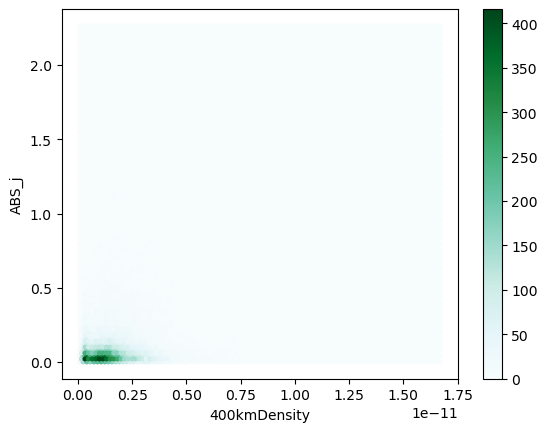

In [104]:
den_amp.plot(x='400kmDensity',y='ABS_j',kind='hexbin')

<Axes: xlabel='ABS_j', ylabel='400kmDensity'>

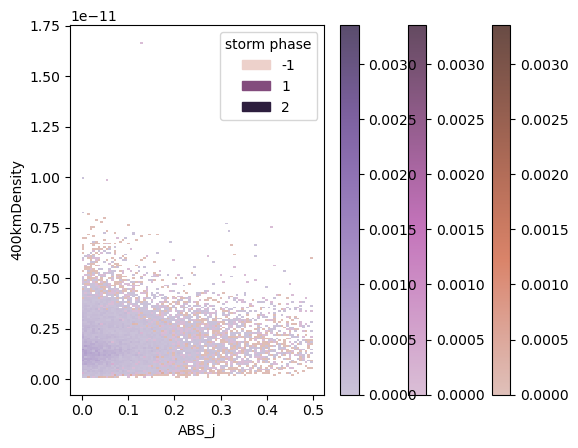

In [135]:
sns.histplot(data=den_amp[den_amp['ABS_j']<0.5], x='ABS_j',y='400kmDensity',cbar=True, stat='probability', hue='storm phase')